# 利用Self-Attention进行时间序列预测

本Notebook利用股市时间序列数据集来展示self-attention的训练和测试流程

## 1. 加载数据

In [ ]:
!wget https://raw.githubusercontent.com/Liadrinz/ml-tutorial/refs/heads/main/MARUTI.csv

--2024-12-04 13:44:08--  https://raw.githubusercontent.com/Liadrinz/ml-tutorial/refs/heads/main/MARUTI.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 488885 (477K) [text/plain]
Saving to: ‘MARUTI.csv.1’

MARUTI.csv.1        100%[===================>] 477.43K  --.-KB/s    in 0.05s   

2024-12-04 13:44:08 (9.62 MB/s) - ‘MARUTI.csv.1’ saved [488885/488885]



In [ ]:
import pandas as pd
import numpy as np
import torch

from torch import nn
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR
from scipy.special import softmax

In [ ]:
np.random.seed(42)
torch.random.manual_seed(42)
torch.manual_seed(42)

In [ ]:
data = pd.read_csv("MARUTI.csv")

In [ ]:
data

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2003-07-09,MARUTI,EQ,125.00,164.90,170.40,155.00,164.00,164.30,165.95,35164283,5.835528e+14,NaN,8537695.0,0.2428
1,2003-07-10,MARUTI,EQ,164.30,167.00,168.70,164.50,167.00,167.00,166.74,10464179,1.744820e+14,NaN,4363947.0,0.4170
2,2003-07-11,MARUTI,EQ,167.00,167.75,174.85,166.25,173.60,173.35,172.45,11740117,2.024622e+14,NaN,3014852.0,0.2568
3,2003-07-14,MARUTI,EQ,173.35,174.25,179.25,174.25,178.60,177.95,177.91,5982324,1.064313e+14,NaN,1949217.0,0.3258
4,2003-07-15,MARUTI,EQ,177.95,200.00,200.00,173.00,176.30,176.20,176.88,6173689,1.092001e+14,NaN,1307694.0,0.2118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4093,2019-12-24,MARUTI,EQ,7360.90,7397.00,7423.70,7302.00,7319.50,7327.80,7373.16,850537,6.271145e+14,66849.0,140503.0,0.1652
4094,2019-12-26,MARUTI,EQ,7327.80,7334.00,7343.45,7222.00,7237.25,7240.90,7282.31,556360,4.051589e+14,41162.0,105301.0,0.1893
4095,2019-12-27,MARUTI,EQ,7240.90,7268.00,7368.50,7251.40,7354.20,7344.90,7302.96,665383,4.859265e+14,44849.0,182392.0,0.2741
4096,2019-12-30,MARUTI,EQ,7344.90,7378.00,7431.95,7341.60,7415.00,7416.25,7387.18,739631,5.463787e+14,57365.0,234375.0,0.3169


把我们需要的列选出来

In [ ]:
data_selected = data[["Date", "Prev Close", "Open", "High", "Low", "Last", "Close"]]

In [ ]:
data_selected

,Date,Prev Close,Open,High,Low,Last,Close
0,2003-07-09,125.00,164.90,170.40,155.00,164.00,164.30
1,2003-07-10,164.30,167.00,168.70,164.50,167.00,167.00
2,2003-07-11,167.00,167.75,174.85,166.25,173.60,173.35
3,2003-07-14,173.35,174.25,179.25,174.25,178.60,177.95
4,2003-07-15,177.95,200.00,200.00,173.00,176.30,176.20
...,...,...,...,...,...,...,...
4093,2019-12-24,7360.90,7397.00,7423.70,7302.00,7319.50,7327.80
4094,2019-12-26,7327.80,7334.00,7343.45,7222.00,7237.25,7240.90
4095,2019-12-27,7240.90,7268.00,7368.50,7251.40,7354.20,7344.90
4096,2019-12-30,7344.90,7378.00,7431.95,7341.60,7415.00,7416.25


## 2. 任务和函数定义

我们希望能用前**3-5**个交易日的数据（6项：前一收盘价、开盘价、最高价、最低价、最后成交价、收盘价）预测下一个交易日的开盘价。

设$X$是前3-5个交易日的数据，那么$X$是一个$n\times6$的矩阵，$n=3,4,5$.

$X=(\mathbf{x}_1,\mathbf{x}_2,\cdots,\mathbf{x}_n)$，每个向量$\mathbf{x}_i$是一个交易日的数据。

$y$是下一个交易日的开盘价格。

我们的目标是找到一个函数$f$，使得$y=f(X)$.

Self-Attention可以很好地处理$X$这种不固定长度的向量序列。

我们先把[Self Attention Tutorial](https://colab.research.google.com/drive/1iTQrUxxwbvapAwvoEXatL64u2a21nnPy#scrollTo=dkwIKog3ak-y)中总结的self-attention函数复制过来进行一些修改，将参数$W^q,W^k,W^v$都设为6x6的方形矩阵。

In [ ]:
def self_attention(X):
    W_q = np.random.randn(6, 6)
    W_k = np.random.randn(6, 6)
    W_v = np.random.randn(6, 6)
    Q = X @ W_q
    K = X @ W_k
    V = X @ W_v
    attention_scores = softmax(Q @ K.T, axis=-1)
    Y = attention_scores @ V
    return Y

然后用一组数据测试一下函数是否能进行运算：

In [ ]:
X = np.array(data_selected.iloc[:4, 1:7])
H = self_attention(X)

可以看到，`self_attention`输出了与原始输入形状一致一个向量序列

In [ ]:
H

array([[-118.76702047,  -90.5414419 , -454.24948915,  224.53671181,
         185.8639328 , -330.93130129],
       [-118.76702047,  -90.5414419 , -454.24948915,  224.53671181,
         185.8639328 , -330.93130129],
       [-118.76702047,  -90.5414419 , -454.24948915,  224.53671181,
         185.8639328 , -330.93130129],
       [-118.76702047,  -90.5414419 , -454.24948915,  224.53671181,
         185.8639328 , -330.93130129]])

In [ ]:
H.shape

(4, 6)

In [ ]:
X.shape

(4, 6)

## 3. 封装torch模型

在[Neural Network Tutorial](https://colab.research.google.com/drive/1nWz3-wz9WouCE6KW_Yn4m6HzGQM39VSC#scrollTo=3QSeelx8IT6Y)中提到过，为了进行训练，我们要把self-attention封装成一个`nn.Module`模块

In [ ]:
class SelfAttention(nn.Module):

  def __init__(self):
    super().__init__()
    self.W_q = nn.Parameter(torch.randn(6, 6))
    self.W_k = nn.Parameter(torch.randn(6, 6))
    self.W_v = nn.Parameter(torch.randn(6, 6))
    self.softmax = nn.Softmax(-1)

  def forward(self, X):
    Q = X @ self.W_q
    K = X @ self.W_k
    V = X @ self.W_v
    attention_scores = self.softmax(Q @ K.T)
    Y = attention_scores @ V
    return Y

self_attention_module = SelfAttention()
self_attention_module(torch.tensor(X, dtype=torch.float32))

tensor([[-499.4633,  370.6825, 1100.7992,  643.9886, -173.1711,  343.9676],
        [-499.4633,  370.6825, 1100.7992,  643.9886, -173.1711,  343.9676],
        [-499.4633,  370.6825, 1100.7992,  643.9886, -173.1711,  343.9676],
        [-499.4633,  370.6825, 1100.7992,  643.9886, -173.1711,  343.9676]],
       grad_fn=<MmBackward0>)

## 4. 一些Tricks

上面`SelfAttention`函数输出的结果有些奇怪，输出了4个相同的向量。

把`softmax`前后的`attention_scores`打印出来可以发现：

- `softmax`之前，注意力分数的数量级很大，都是$10^5$级别的
- 经过`softmax`后，只有一列是1，其他位置都是0

In [ ]:
class SelfAttention(nn.Module):

  def __init__(self):
    super().__init__()
    self.W_q = nn.Parameter(torch.randn(6, 6))
    self.W_k = nn.Parameter(torch.randn(6, 6))
    self.W_v = nn.Parameter(torch.randn(6, 6))
    self.softmax = nn.Softmax(-1)

  def forward(self, X):
    Q = X @ self.W_q
    K = X @ self.W_k
    V = X @ self.W_v
    attention_scores = Q @ K.T
    print(attention_scores)
    attention_scores = self.softmax(attention_scores)
    print(attention_scores)
    Y = attention_scores @ V
    return Y

self_attention_module = SelfAttention()
self_attention_module(torch.tensor(X, dtype=torch.float32))

tensor([[451053.6250, 470461.4375, 480011.5000, 495996.7188],
        [529195.3125, 552199.7500, 562567.8750, 581724.2500],
        [548142.8750, 571568.6875, 582370.5625, 602166.4375],
        [562730.3750, 587006.2500, 598057.0000, 618403.8750]],
       grad_fn=<MmBackward0>)
tensor([[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]], grad_fn=<SoftmaxBackward0>)


tensor([[  23.0905, -694.8510,  610.4684,  427.4961, -288.8658, -148.9294],
        [  23.0905, -694.8510,  610.4684,  427.4961, -288.8658, -148.9294],
        [  23.0905, -694.8510,  610.4684,  427.4961, -288.8658, -148.9294],
        [  23.0905, -694.8510,  610.4684,  427.4961, -288.8658, -148.9294]],
       grad_fn=<MmBackward0>)

从经验来看，可能是因为我们随机初始化的参数`W^q,W^k,W^v`的数量级太大。

`torch.randn(a, b)`默认产生一系列服从标准正态分布的随机数（均值为0，标准差为1），然后填充到形状为`(a, b)`的矩阵中。

我们可以调小标准差的数量级，从1调至0.01：

In [ ]:
class SelfAttention(nn.Module):

  def __init__(self):
    super().__init__()
    self.W_q = nn.Parameter(torch.randn(6, 6) / 100)
    self.W_k = nn.Parameter(torch.randn(6, 6) / 100)
    self.W_v = nn.Parameter(torch.randn(6, 6) / 100)
    self.softmax = nn.Softmax(-1)

  def forward(self, X):
    Q = X @ self.W_q
    K = X @ self.W_k
    V = X @ self.W_v
    attention_scores = Q @ K.T
    print(attention_scores)
    attention_scores = self.softmax(attention_scores)
    print(attention_scores)
    Y = attention_scores @ V
    return Y

self_attention_module = SelfAttention()
self_attention_module(torch.tensor(X, dtype=torch.float32))

tensor([[22.7238, 26.1755, 25.8179, 26.9629],
        [23.0903, 27.1591, 26.7285, 27.9385],
        [23.9255, 28.0852, 27.6483, 28.8961],
        [24.4905, 28.8076, 28.3517, 29.6352]], grad_fn=<MmBackward0>)
tensor([[0.0081, 0.2545, 0.1780, 0.5594],
        [0.0044, 0.2599, 0.1690, 0.5667],
        [0.0040, 0.2557, 0.1652, 0.5752],
        [0.0034, 0.2541, 0.1611, 0.5814]], grad_fn=<SoftmaxBackward0>)


tensor([[-0.7230, -1.7021, -2.9081,  3.9040, -0.9363,  2.1705],
        [-0.7226, -1.7039, -2.9097,  3.9048, -0.9374,  2.1702],
        [-0.7229, -1.7044, -2.9109,  3.9064, -0.9379,  2.1710],
        [-0.7230, -1.7050, -2.9118,  3.9073, -0.9384,  2.1714]],
       grad_fn=<MmBackward0>)

这样计算出来的`attention_scores`和最终的输出`Y`都不是极端的数值。

- 极端的数值可能意味着参数初始化的错误。
- 极端的数值可能不利于梯度的计算。

## 5. 批量矩阵乘法和Broadcast的概念

批量化矩阵乘法：

In [ ]:
A = torch.randn(3, 5, 4)
B = torch.randn(3, 4, 5)
C = A @ B
C.size()

torch.Size([3, 5, 5])

不管前面有多少维，需要保证最后两维的形状符合矩阵乘法规则，且前面的维度对应相同：

In [ ]:
A = torch.randn(3, 4, 2, 5, 4)
B = torch.randn(3, 4, 2, 4, 5)
C = A @ B
C.size()

torch.Size([3, 4, 2, 5, 5])

转置不能再用`T`，因为`T`本质上转置的是第一维和最后一维：

In [ ]:
A = torch.randn(3, 5, 4)
A.T.size()

<ipython-input-18-5ddffc5339c1>:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  A.T.size()


torch.Size([4, 5, 3])

批量的矩阵乘法应该转置倒数第二和倒数第一维；

下面的例子使用`transpose(1, 2)`转置了第二维（索引1）和第三维（索引2）：

In [ ]:
A = torch.randn(3, 5, 4)
B = torch.randn(3, 5, 4)
C = A @ B.transpose(1, 2)
C.size()

torch.Size([3, 5, 5])

批量矩阵乘法支持broadcast.

什么是broadcast？例如，一个向量加上一个标量，这个标量会被加到向量的每个元素上：

In [ ]:
x = torch.tensor([1.0, 2.0, 3.0])
s = torch.tensor(0.5)
x + s

tensor([1.5000, 2.5000, 3.5000])

一个矩阵加上一个 行/列 向量，这个 行/列 向量会被加到矩阵的每一 行/列：

In [ ]:
A = torch.zeros(4, 3)
x = torch.tensor([1.0, 2.0, 3.0])
A + x

tensor([[1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.]])

In [ ]:
B = torch.zeros(4, 3)
y = torch.tensor([
    [1.0],
    [2.0],
    [3.0],
    [4.0],
])
B + y

tensor([[1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.],
        [4., 4., 4.]])

但是并非所有形状不匹配的tensor进行运算都能发生broadcast

一个形状为`(4, 3)`的矩阵与形状为`(4, 1)`和`(1, 3)`的矩阵相加都可以发生broadcast

但是与形状为`(4, 2)`或`(2, 3)`的矩阵相加会发生错误：

In [ ]:
A = torch.randn(4, 3)
B = torch.randn(4, 1)
A + B

tensor([[ 1.5509,  1.2795,  1.1821],
        [ 0.6343,  0.0106,  1.7354],
        [ 4.4817,  0.1474,  1.5750],
        [-0.7164, -2.3884, -2.2045]])

In [ ]:
A = torch.randn(4, 3)
B = torch.randn(1, 3)
A + B

tensor([[ 0.7389, -0.0661, -0.7843],
        [ 1.4201,  0.5694, -1.3937],
        [ 1.2893,  1.2604, -1.6130],
        [ 1.7330, -1.4413,  0.1327]])

In [ ]:
# A = torch.randn(4, 3)
# B = torch.randn(4, 2)
# A + B

In [ ]:
# A = torch.randn(4, 3)
# B = torch.randn(2, 3)
# A + B

矩阵乘法的broadcast:

In [ ]:
A = torch.randn(3, 5, 4)
B = torch.randn(4, 5)
C1 = A @ B
C2 = B @ A

`C1`表示将`A`中的3个`(5, 4)`的矩阵分别与`B`这一个`(4, 5)`的矩阵相乘

`C2`表示将`B`这一个`(4, 5)`的矩阵与`A`中的3个`(5, 4)`的矩阵分别相乘

In [ ]:
C1.size()

torch.Size([3, 5, 5])

In [ ]:
C2.size()

torch.Size([3, 4, 4])

## 6. 批量化`SelfAttention`

我们将`SelfAttention`中的矩阵运算批量化，使其可以接收批量的`X`:

In [ ]:
class SelfAttention(nn.Module):

  def __init__(self):
    super().__init__()
    self.W_q = nn.Parameter(torch.randn(6, 6) / 100)
    self.W_k = nn.Parameter(torch.randn(6, 6) / 100)
    self.W_v = nn.Parameter(torch.randn(6, 6) / 100)
    self.softmax = nn.Softmax(-1)

  def forward(self, X):
    Q = X @ self.W_q
    K = X @ self.W_k
    V = X @ self.W_v
    attention_scores = Q @ K.transpose(1, 2)  # 转置后两维
    attention_scores = self.softmax(attention_scores)
    Y = attention_scores @ V
    return Y

self_attention_module = SelfAttention()
X_batch = torch.tensor(X, dtype=torch.float32).unsqueeze(0)  # 增加一个维度，模拟batch=1的输入
print(X_batch.shape)
H_batch = self_attention_module(X_batch)
print(H_batch.shape)

torch.Size([1, 4, 6])
torch.Size([1, 4, 6])


## 7. 搭建最终数值预测模型

搭建最终的数值预测模型需要以下（可训练）模块：

- SelfAttention：提取序列特征
- FNN：全连接神经网络，两个线性层，进一步提取每个位置的特征
- 数值输出头：线性层，将特征映射为最终的输出值

另外还需要引入以下机制：

- 激活函数：使函数具有非线性特征，可以建模非线性的关系
- 池化（Pooling）：后面详细讲

这里我们**没有**用到：


- 残差连接：将输入加到输出上，避免梯度消失
- 层归一化：对SelfAttention的输出向量进行归一化，使梯度更加稳定

因为我们的网络很浅，梯度本身就可以比较稳定地回传。

In [ ]:
class SelfAttentionPredictModel(nn.Module):

  def __init__(self):
    super().__init__()
    self.attn = SelfAttention()
    self.fnn = nn.Sequential(
        nn.Linear(6, 16),
        nn.Linear(16, 6)
    )
    self.act = nn.ReLU()
    self.pred_head = nn.Linear(6, 1)

  def forward(self, X):
    H_attn = self.attn(X)
    H_fnn = self.fnn(H_attn)
    H_act = self.act(H_fnn)
    H_pooled = H_act.mean(dim=1)  # 池化
    y = self.pred_head(H_pooled) * 100  # 输出头
    return y.squeeze(-1)

网络的架构图如下。整体流程为：

1. 原始输入`X`（黄色，前3-5个交易日的数据序列）经过SelfAttention后得到`H_attn`（绿色，每个向量包含所有输入交易日的信息）
2. `H_attn`（绿色）经过FNN得到`H_fnn`（橙色），这一步每个向量不关心其他向量，各自单独经过FNN
3. 对所有`H_fnn`（橙色）取均值得到一个向量`H_pooled`（灰色），这一步称为池化
4. 将`H_pooled`（灰色）输入PredictionHead得到最终的输出，这一输出用来表示下一个交易日的开盘价

**池化（Pooling）是什么？**

Pooling这一概念兴起于卷积神经网络（Convolutional Neural Network, CNN）。

CNN中需要对往往需要对提取到的特征图（feature map）进行降维，一种常见的做法就是取每个2x2的区域的最大值或平均值，前者叫Max Pooling，后者叫Average/Mean Pooling.

**我们为什么也需要Pooling？**

在基于SelfAttention的模型中，输入序列`X`的长度是不固定的。

但是最后需要做 分类/回归 预测时，需要有一个固定大小的向量来“承载”整个序列的特征。

我们的做法是对`H_fnn`（橙色）中所有输出向量取平均，可以看作一种Average Pooling

还有一种常见的做法是直接取某个位置的向量来承载整个序列的特征，因为`SelfAttention`输出的每个向量都包含了输入序列`X`中每个向量的信息，所以理论上可以用输出向量序列中的任一向量来表示整个序列的特征：

- BERT: 使用BERT架构的模型做句子分类时，输出向量序列中的第1个向量会被用来作为整个句子的特征向量
- GPT: 使用GPT架构的模型做句子分类时，输出向量序列中的最后一个向量会被用来作为整个句子的特征向量

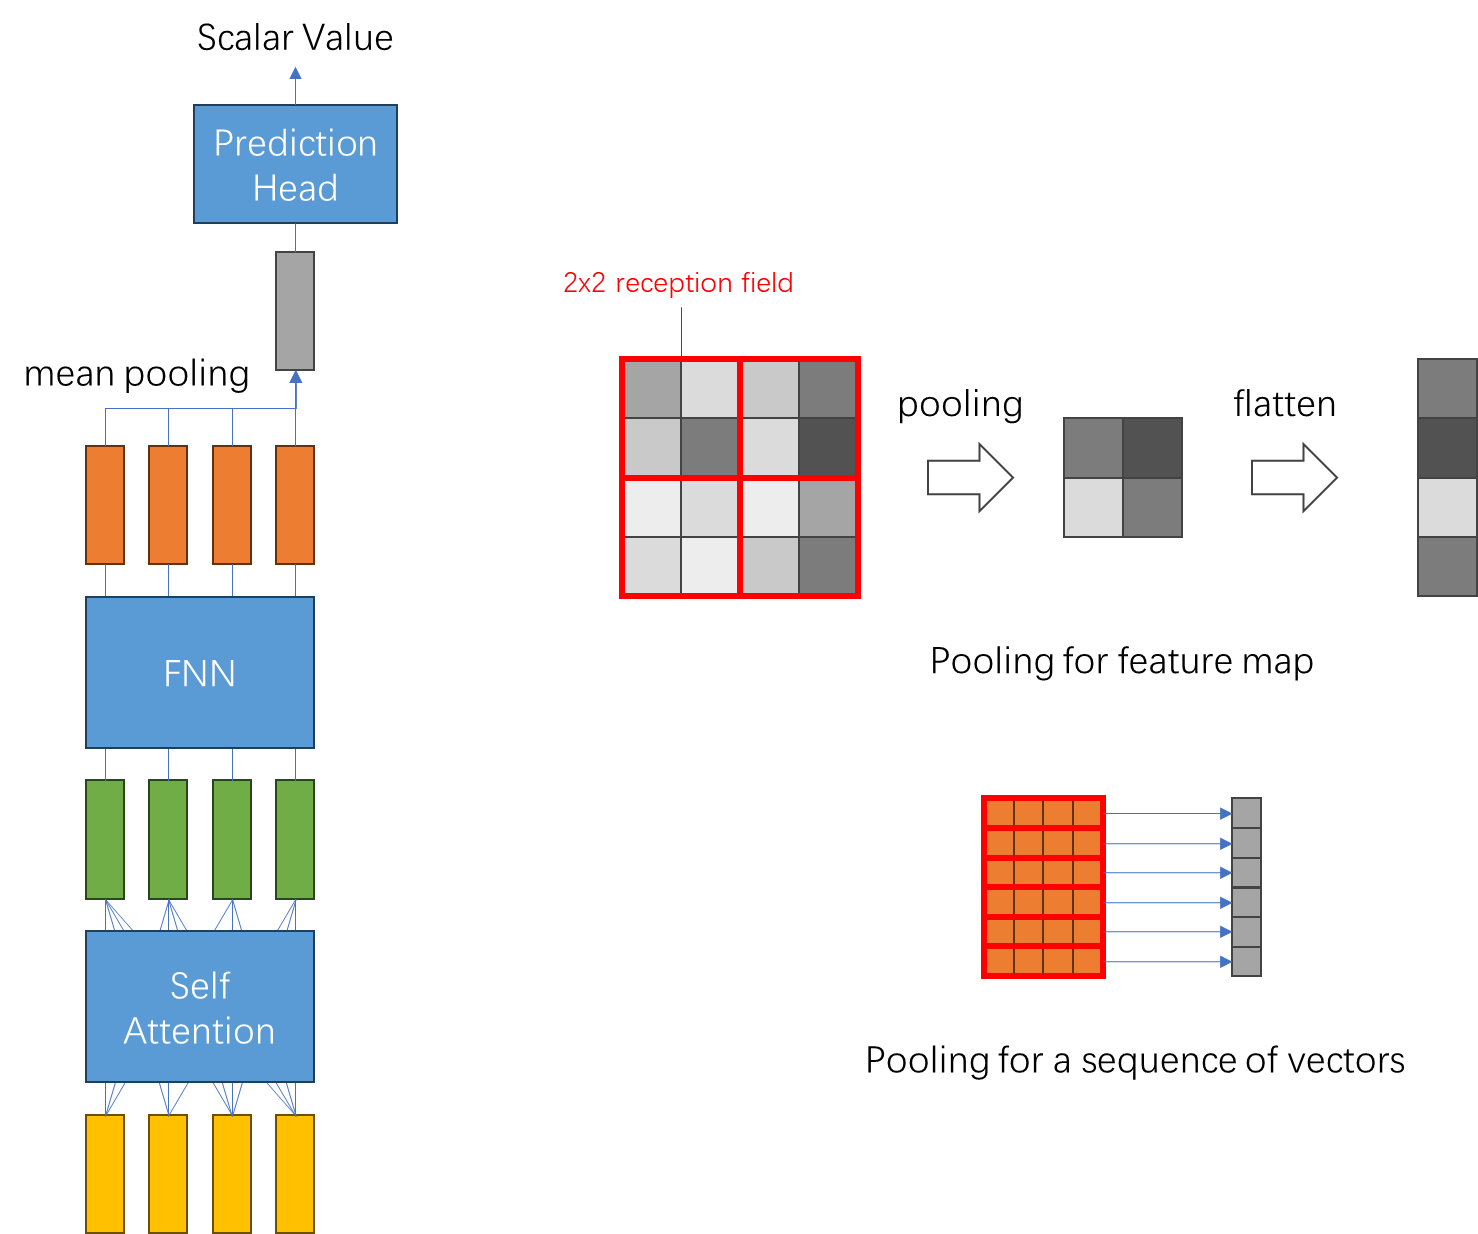

## 8. PyTorch数据集（Dataset）和数据加载器（DataLoader）

把DataFrame封装成pytorch数据集：

In [ ]:
data_train = data_selected.iloc[:-100]
data_test = data_selected.iloc[-100:]


class StockDataset(Dataset):

  def __init__(self, data_frame):
    super().__init__()
    self.data = data_frame.iloc[:, 1:]

  def __getitem__(self, idx):
    i = idx + 5  # 跳过最开始的5个交易日
    y = self.data["Open"].iloc[i]
    seq_len = np.random.randint(3, 6)  # 随机考虑3-5个交易日
    X = self.data.iloc[i-seq_len:i]
    return np.array(X), np.array(y)

  def __len__(self):
    return len(self.data) - 5


dataset_train = StockDataset(data_train)
dataset_test = StockDataset(data_test)

In [ ]:
len(dataset_train)

3993

In [ ]:
len(dataset_test)

95

In [ ]:
dataset_train[0]

(array([[167.  , 167.75, 174.85, 166.25, 173.6 , 173.35],
        [173.35, 174.25, 179.25, 174.25, 178.6 , 177.95],
        [177.95, 200.  , 200.  , 173.  , 176.3 , 176.2 ]]),
 array(176.45))

将数据集封装到`DataLoader`中，按batch遍历。这里`batch_size`先设为1，之后讲如何将不同长度的序列攒成batch.

In [ ]:
loader_train = DataLoader(dataset_train, batch_size=1)
loader_test = DataLoader(dataset_test, batch_size=1)

数据集被封装成了可遍历的`DataLoader`对象：

In [ ]:
for batch in loader_train:
  X, y = batch
  print(X.shape)
  print(y.shape)
  print(X)
  print(y)
  break

torch.Size([1, 4, 6])
torch.Size([1])
tensor([[[164.3000, 167.0000, 168.7000, 164.5000, 167.0000, 167.0000],
         [167.0000, 167.7500, 174.8500, 166.2500, 173.6000, 173.3500],
         [173.3500, 174.2500, 179.2500, 174.2500, 178.6000, 177.9500],
         [177.9500, 200.0000, 200.0000, 173.0000, 176.3000, 176.2000]]],
       dtype=torch.float64)
tensor([176.4500], dtype=torch.float64)


## 9. 训练和测试

先创建模型：

In [ ]:
model = SelfAttentionPredictModel()

在训练之前先测试模型在测试集上的预测误差，可以看到误差达到了100%

In [ ]:
total_error = []
for X, y in loader_test:
  X = torch.tensor(X, dtype=torch.float32)
  y = torch.tensor(y, dtype=torch.float32)
  with torch.no_grad():
    y_pred = model(X)
  error = (y_pred - y).abs() / y.abs()
  total_error.append(error)
avg_error = sum(total_error) / len(total_error)
print(f"Error: {avg_error.item()*100:.2f}%")

<ipython-input-39-ab9b3b1a218f>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
<ipython-input-39-ab9b3b1a218f>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)


Error: 59.39%


接下来就是创建一个优化器，并用优化器来优化模型的参数，即训练模型。

这里用到了`LinearLR`作为学习率调度器，可以在训练过程中动态地调整学习率。

我们把优化器中设定的学习率`2e-4`称为原始学习率，则：

- `start_factor=1.0`表示训练开始时的学习率为原始学习率的1.0倍，即`2e-4`
- `end_factor=0.5`表示训练结束时的学习率为原始学习率的`0.5`倍，即`1e-4`
- `total_iters`表示从`start_factor`变化到`end_factor`需要的步数

这里我们一边训练一边打印`loss`和学习率：

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-4)
num_train_epochs = 20
scheduler = LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=num_train_epochs)


def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']


for i_epoch in range(num_train_epochs):
  total_loss = []
  for X, y in loader_train:
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    y_pred = model(X)
    loss = (y_pred - y) ** 2  # 均方误差
    total_loss.append(loss)
  avg_loss = sum(total_loss) / len(total_loss)
  print("="*100)
  print("Loss:", avg_loss.item())
  print("LR:", get_lr(optimizer))
  print("="*100)
  optimizer.zero_grad()
  avg_loss.backward()
  optimizer.step()
  scheduler.step()  # 调整学习率

<ipython-input-40-80d4f698abfd>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
<ipython-input-40-80d4f698abfd>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)


Loss: 4498435.5
LR: 0.0005
Loss: 3771024.75
LR: 0.0004875
Loss: 2874947.75
LR: 0.00047499999999999994
Loss: 1962572.875
LR: 0.00046249999999999997
Loss: 1195314.375
LR: 0.00045
Loss: 599574.8125
LR: 0.0004375
Loss: 221301.484375
LR: 0.00042500000000000003
Loss: 39062.50390625
LR: 0.00041250000000000005
Loss: 11920.4580078125
LR: 0.0004000000000000001
Loss: 90746.0625
LR: 0.0003875000000000001
Loss: 218228.609375
LR: 0.0003750000000000001
Loss: 347528.46875
LR: 0.00036250000000000014
Loss: 440296.53125
LR: 0.00035000000000000016
Loss: 481792.53125
LR: 0.0003375000000000002
Loss: 479673.8125
LR: 0.0003250000000000002
Loss: 436930.78125
LR: 0.0003125000000000002
Loss: 372052.875
LR: 0.0003000000000000002
Loss: 297712.40625
LR: 0.0002875000000000002
Loss: 223655.125
LR: 0.00027500000000000023
Loss: 157516.6875
LR: 0.00026250000000000025


训练完成后在测试集上评估预测误差，相比训练之前有显著的下降

（虽然对于实际股票场景来说差得还是很离谱，但对于这么小的模型来说已经很厉害了）：

In [ ]:
total_error = []
predictions = []
for X, y in loader_test:
  X = torch.tensor(X, dtype=torch.float32)
  y = torch.tensor(y, dtype=torch.float32)
  with torch.no_grad():
    y_pred = model(X)
  predictions.append(y_pred.item())
  error = (y_pred - y).abs() / y.abs()
  total_error.append(error)
avg_error = sum(total_error) / len(total_error)
print(f"Error: {avg_error.item()*100:.2f}%")

Error: 8.14%


<ipython-input-41-ee3b141bb733>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
<ipython-input-41-ee3b141bb733>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)


我们可以把预测值的开盘价和真实的开盘价放在一个表中进行一个直观的对比：

In [ ]:
data_test.insert(3, "Open (Predicted)", 0)

In [ ]:
data_test["Open (Predicted)"][5:] = predictions

<ipython-input-43-febcd6bc6301>:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_test["Open (Predicted)"][5:] = predictions
<ipython-input-43-febcd6bc6301>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [ ]:
data_test

,Date,Prev Close,Open,Open (Predicted),High,Low,Last,Close
3998,2019-08-01,5469.70,5469.70,0.000000,5615.00,5450.00,5586.00,5572.60
3999,2019-08-02,5572.60,5539.60,0.000000,5724.00,5485.00,5710.00,5689.35
4000,2019-08-05,5689.35,5600.00,0.000000,5695.00,5452.00,5667.50,5670.35
4001,2019-08-06,5670.35,5640.00,0.000000,5849.00,5640.00,5830.00,5833.30
4002,2019-08-07,5833.30,5833.95,0.000000,5867.00,5735.70,5736.00,5775.00
...,...,...,...,...,...,...,...,...
4093,2019-12-24,7360.90,7397.00,7856.812988,7423.70,7302.00,7319.50,7327.80
4094,2019-12-26,7327.80,7334.00,7904.247070,7343.45,7222.00,7237.25,7240.90
4095,2019-12-27,7240.90,7268.00,7904.247070,7368.50,7251.40,7354.20,7344.90
4096,2019-12-30,7344.90,7378.00,7904.247070,7431.95,7341.60,7415.00,7416.25


## 10. 填充和批量化（Padding & Batching）

[Neural Network Tutorial](https://colab.research.google.com/drive/1nWz3-wz9WouCE6KW_Yn4m6HzGQM39VSC#scrollTo=3QSeelx8IT6Y)中使用的Iris数据集中，每条输入都是形状完全相同的向量（长度为4），因此要将它们攒成一个batch很简单，直接拼起来变成矩阵就可以。

但是我们的场景中，输入序列的长度3到5是不固定的，单条数据的大小是形状为`(n, 6)`的矩阵，其中`n=3,4,5`，没有办法直接拼起来。

我们可以再封装一个数据集，把所有的输入序列都填充到最大长度（5）：

In [ ]:
class PaddedStockDataset(Dataset):

  def __init__(self, org_dataset):
    self.org_dataset = org_dataset

  def __getitem__(self, idx):
    X, y = self.org_dataset[idx]
    pad_len = 5 - X.shape[0]
    padding = np.zeros((pad_len, 6))
    X_padded = np.concatenate([X, padding])
    return X_padded, y


  def __len__(self):
    return len(self.org_dataset)

In [ ]:
padded_dataset_train = PaddedStockDataset(dataset_train)
padded_dataset_test = PaddedStockDataset(dataset_test)

In [ ]:
padded_dataset_train[2]

(array([[173.35, 174.25, 179.25, 174.25, 178.6 , 177.95],
        [177.95, 200.  , 200.  , 173.  , 176.3 , 176.2 ],
        [176.2 , 176.45, 179.1 , 175.35, 176.9 , 177.1 ],
        [177.1 , 177.5 , 178.  , 170.65, 170.7 , 172.2 ],
        [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ]]),
 array(165.))

In [ ]:
padded_dataset_test[3]

(array([[5670.35, 5640.  , 5849.  , 5640.  , 5830.  , 5833.3 ],
        [5833.3 , 5833.95, 5867.  , 5735.7 , 5736.  , 5775.  ],
        [5775.  , 5725.  , 5947.  , 5725.  , 5934.25, 5902.25],
        [5902.25, 5937.65, 6155.  , 5927.2 , 6100.25, 6099.9 ],
        [6099.9 , 6099.7 , 6123.  , 5791.55, 5792.  , 5815.45]]),
 array(5792.))

但是这样有一个很显然的问题，就是我们填充进去的0是有含义的。

模型不知道这个0单纯是用来填充的，它会单纯地认为这个交易日的所有数据都是0，并且进行计算。

怎样让填充的部分不参与计算？

这就需要引入`attention_mask`的概念了。

`attention_mask`是一个01向量（或者布尔向量），用来区分输入的向量序列`X`中哪些位置需要参与计算，哪些位置是填充内容或没有意义，不需要参与计算。

我们可以在`PaddedStockDataset`为每条数据加入`attention_mask`：

In [ ]:
class PaddedStockDataset(Dataset):

  def __init__(self, org_dataset):
    self.org_dataset = org_dataset

  def __getitem__(self, idx):
    X, y = self.org_dataset[idx]
    pad_len = 5 - X.shape[0]
    padding = np.zeros((pad_len, 6))
    X_padded = np.concatenate([X, padding])
    attention_mask = np.array([1 if i < X.shape[0] else 0 for i in range(5)])
    return X_padded, y, attention_mask


  def __len__(self):
    return len(self.org_dataset)


padded_dataset_train = PaddedStockDataset(dataset_train)
padded_dataset_test = PaddedStockDataset(dataset_test)
padded_dataset_train[2]

(array([[173.35, 174.25, 179.25, 174.25, 178.6 , 177.95],
        [177.95, 200.  , 200.  , 173.  , 176.3 , 176.2 ],
        [176.2 , 176.45, 179.1 , 175.35, 176.9 , 177.1 ],
        [177.1 , 177.5 , 178.  , 170.65, 170.7 , 172.2 ],
        [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ]]),
 array(165.),
 array([1, 1, 1, 1, 0]))

接下来需要改造`SelfAttention`模块以及`SelfAttentionPredictModel`，使其能接收`attention_mask`作为输入，并根据`attention_mask`调整计算过程：

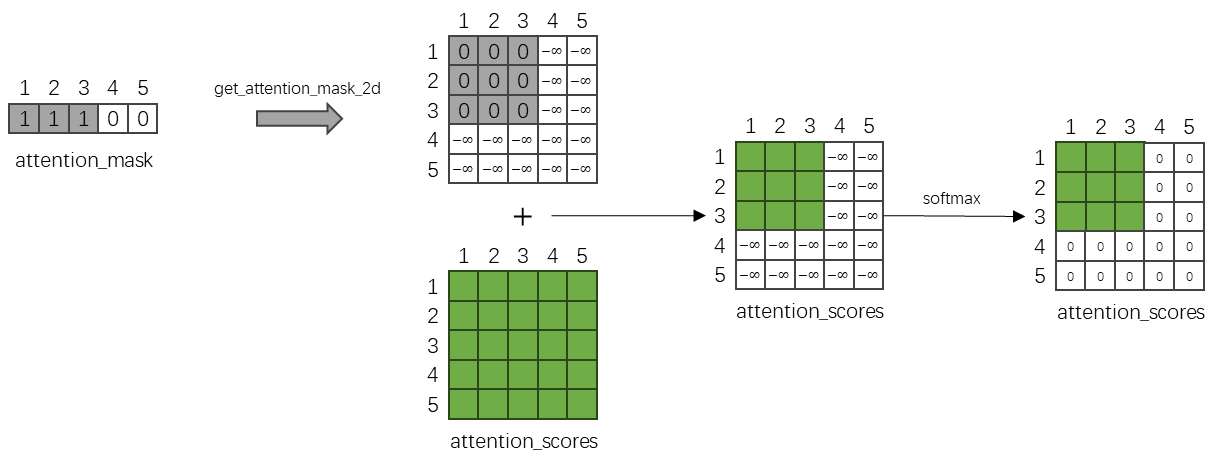

In [ ]:
class SelfAttention(nn.Module):

  def __init__(self):
    super().__init__()
    self.W_q = nn.Parameter(torch.randn(6, 6) / 100)
    self.W_k = nn.Parameter(torch.randn(6, 6) / 100)
    self.W_v = nn.Parameter(torch.randn(6, 6) / 100)
    self.softmax = nn.Softmax(-1)

  @staticmethod
  def get_attention_mask_2d(attention_mask):
    batch_size = attention_mask.size(0)
    mask_len = attention_mask.size(1)
    attention_mask_2d = attention_mask[:, None, :].expand(batch_size, mask_len, mask_len).to(torch.float32)
    inverted_mask = 1.0 - attention_mask_2d
    return inverted_mask.masked_fill(inverted_mask.to(torch.bool), torch.finfo(torch.float32).min)

  def forward(self, X, attention_mask):
    Q = X @ self.W_q
    K = X @ self.W_k
    V = X @ self.W_v
    attention_scores = Q @ K.transpose(1, 2)

    attention_mask_2d = self.get_attention_mask_2d(attention_mask)  # 获取二维的attention_mask
    attention_scores = self.softmax(attention_scores + attention_mask_2d)  # 将attention_mask应用到attention_scores上

    Y = attention_scores @ V
    return Y


class SelfAttentionPredictModel(nn.Module):

  def __init__(self):
    super().__init__()
    self.attn = SelfAttention()
    self.fnn = nn.Sequential(
        nn.Linear(6, 16),
        nn.Linear(16, 6)
    )
    self.act = nn.ReLU()
    self.pred_head = nn.Linear(6, 1)

  def forward(self, X, attention_mask):
    H_attn = self.attn(X, attention_mask)
    H_fnn = self.fnn(H_attn)
    H_act = self.act(H_fnn)

    # 忽略填充的部分求均值
    H_pooled = H_act.sum(dim=1) / attention_mask.sum(dim=1, keepdim=True)

    y = self.pred_head(H_pooled) * 100  # 输出头
    return y.squeeze(-1)

现在我们就可以开始批量训练了：

In [ ]:
padded_loader_train = DataLoader(padded_dataset_train, batch_size=4)
padded_loader_test = DataLoader(padded_dataset_test, batch_size=4)

In [ ]:
for batch in padded_loader_train:
  print(batch)
  break

[tensor([[[167.0000, 167.7500, 174.8500, 166.2500, 173.6000, 173.3500],
         [173.3500, 174.2500, 179.2500, 174.2500, 178.6000, 177.9500],
         [177.9500, 200.0000, 200.0000, 173.0000, 176.3000, 176.2000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000]],

        [[164.3000, 167.0000, 168.7000, 164.5000, 167.0000, 167.0000],
         [167.0000, 167.7500, 174.8500, 166.2500, 173.6000, 173.3500],
         [173.3500, 174.2500, 179.2500, 174.2500, 178.6000, 177.9500],
         [177.9500, 200.0000, 200.0000, 173.0000, 176.3000, 176.2000],
         [176.2000, 176.4500, 179.1000, 175.3500, 176.9000, 177.1000]],

        [[167.0000, 167.7500, 174.8500, 166.2500, 173.6000, 173.3500],
         [173.3500, 174.2500, 179.2500, 174.2500, 178.6000, 177.9500],
         [177.9500, 200.0000, 200.0000, 173.0000, 176.3000, 176.2000],
         [176.2000, 176.4500, 179.1000, 175.3500, 176.9000, 177.1000],
 

In [ ]:
model = SelfAttentionPredictModel()
optimizer = AdamW(model.parameters(), lr=2e-3)
num_train_epochs = 20
scheduler = LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=num_train_epochs)


def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']


for i_epoch in range(num_train_epochs):
  total_loss = []
  for X, y, attention_mask in padded_loader_train:
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    y_pred = model(X, attention_mask)
    loss = ((y_pred - y) ** 2).mean()  # 均方误差
    total_loss.append(loss)
  avg_loss = sum(total_loss) / len(total_loss)
  print("="*100)
  print("Loss:", avg_loss.item())
  print("LR:", get_lr(optimizer))
  print("="*100)
  optimizer.zero_grad()
  avg_loss.backward()
  optimizer.step()
  scheduler.step()  # 调整学习率

<ipython-input-53-192fa594bba0>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
<ipython-input-53-192fa594bba0>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)


Loss: 23973770.0
LR: 0.002
Loss: 12067606.0
LR: 0.00195
Loss: 4132061.75
LR: 0.0018999999999999998
Loss: 808783.0
LR: 0.0018499999999999999
Loss: 1206992.375
LR: 0.0018
Loss: 3152888.5
LR: 0.00175
Loss: 4174752.0
LR: 0.0017000000000000001
Loss: 3376085.75
LR: 0.0016500000000000002
Loss: 2145302.0
LR: 0.0016000000000000003
Loss: 938925.375
LR: 0.0015500000000000004
Loss: 563152.9375
LR: 0.0015000000000000005
Loss: 903043.5
LR: 0.0014500000000000006
Loss: 1477775.5
LR: 0.0014000000000000006
Loss: 1929058.875
LR: 0.0013500000000000007
Loss: 1905837.125
LR: 0.0013000000000000008
Loss: 1611459.75
LR: 0.001250000000000001
Loss: 1159036.375
LR: 0.0012000000000000008
Loss: 833772.9375
LR: 0.0011500000000000008
Loss: 603094.4375
LR: 0.001100000000000001
Loss: 575711.625
LR: 0.001050000000000001


测试同样可以批量进行：

In [ ]:
total_error = []
predictions = []
for X, y, attention_mask in padded_loader_test:
  X = torch.tensor(X, dtype=torch.float32)
  y = torch.tensor(y, dtype=torch.float32)
  with torch.no_grad():
    y_pred = model(X, attention_mask)
  predictions.extend(y_pred.tolist())
  error = ((y_pred - y).abs() / y.abs()).mean()
  total_error.append(error)
avg_error = sum(total_error) / len(total_error)
print(f"Error: {avg_error.item()*100:.2f}%")

data_test.insert(3, "Open (Predicted-4)", 0)
data_test["Open (Predicted-4)"][5:] = predictions
data_test

Error: 15.91%


<ipython-input-54-f9fba0c408f1>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
<ipython-input-54-f9fba0c408f1>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
<ipython-input-54-f9fba0c408f1>:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical exam

,Date,Prev Close,Open,Open (Predicted-4),Open (Predicted),High,Low,Last,Close
3998,2019-08-01,5469.70,5469.70,0.000000,0.000000,5615.00,5450.00,5586.00,5572.60
3999,2019-08-02,5572.60,5539.60,0.000000,0.000000,5724.00,5485.00,5710.00,5689.35
4000,2019-08-05,5689.35,5600.00,0.000000,0.000000,5695.00,5452.00,5667.50,5670.35
4001,2019-08-06,5670.35,5640.00,0.000000,0.000000,5849.00,5640.00,5830.00,5833.30
4002,2019-08-07,5833.30,5833.95,0.000000,0.000000,5867.00,5735.70,5736.00,5775.00
...,...,...,...,...,...,...,...,...,...
4093,2019-12-24,7360.90,7397.00,9752.184570,7856.812988,7423.70,7302.00,7319.50,7327.80
4094,2019-12-26,7327.80,7334.00,5829.142578,7904.247070,7343.45,7222.00,7237.25,7240.90
4095,2019-12-27,7240.90,7268.00,9829.967773,7904.247070,7368.50,7251.40,7354.20,7344.90
4096,2019-12-30,7344.90,7378.00,5905.411621,7904.247070,7431.95,7341.60,7415.00,7416.25
